In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.core.composition import OneOf
import glob
import os
import numpy as np

In [2]:
# 경로 설정

data_path = '/workspace/#Ub370#Uc774#Ud130/Data'

img_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/img/train/'
img_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/img/val/'

json_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/label/train/'
json_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/label/val/'

segment_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/train/'
segment_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/val/'


img_path_train_anger = img_path_train + 'anger/'
img_path_val_anger = img_path_val + 'anger/'

img_path_train_happy = img_path_train + 'happy/'
img_path_val_happy = img_path_val + 'happy/'

img_path_train_panic = img_path_train + 'panic/'
img_path_val_panic = img_path_val + 'panic/'

img_path_train_sadness = img_path_train + 'sadness/'
img_path_val_sadness = img_path_val + 'sadness/'

In [3]:
# Boundind Box 좌표 정보가 담긴 csv 파일

df_train_anger = pd.read_csv(json_path_train + 'train_anger_1.csv')
df_val_anger = pd.read_csv (json_path_val + 'val_anger.csv')

df_train_happy = pd.read_csv(json_path_train + 'train_happy_1.csv')
df_val_happy = pd.read_csv (json_path_val + 'val_happy.csv')

df_train_panic = pd.read_csv(json_path_train + 'train_panic_1.csv')
df_val_panic = pd.read_csv (json_path_val + 'val_panic.csv')

df_train_sadness = pd.read_csv(json_path_train + 'train_sadness_1.csv')
df_val_sadness = pd.read_csv (json_path_val + 'val_sadness.csv')


In [4]:
import numpy as np

# 세그먼트 데이터가 저장된 경로
npz_file_path = "/workspace/#Ub370#Uc774#Ud130/Data/segmentation/val/val_sadness.npz"

# .npz 파일 로드
npz_data = np.load(npz_file_path)

print(npz_data.keys())

# print(npz_data['00skd6f03c1bc8e3f618fb80b7863679bf684363a4d013ad634fab7c647ff8kws.jpg'])

KeysView(NpzFile '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/val/val_sadness.npz' with keys: 01s1cfe4dcc8ce3c8e8a8c6ee9ccb2d1f922fee4006680de336c2629e122bkes0.jpg, 01zi6a5edca7ecd074b1e6425c5be40e0bc067c8968b5eb94c426775ecf6cz0bm.jpg, 092p22db317234a66285221ff97225552522522bdb721e620f0b2af069112k1nc.jpg, 09jg6e5197f56bd8aae631ac30e476e1e07bf06523766a9f9ebaeef23bb0ee3a9.jpg, 0agj233998393f259b5363da94d7349ac39bd98c58a6f9bafad049273b8d3cnic.jpg...)


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


0.0
0.0
0.0
0.0


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


rb04c532132d836a981bf48f70b3588730632285f2c97b347e1cdb4fa1133mcty.jpg


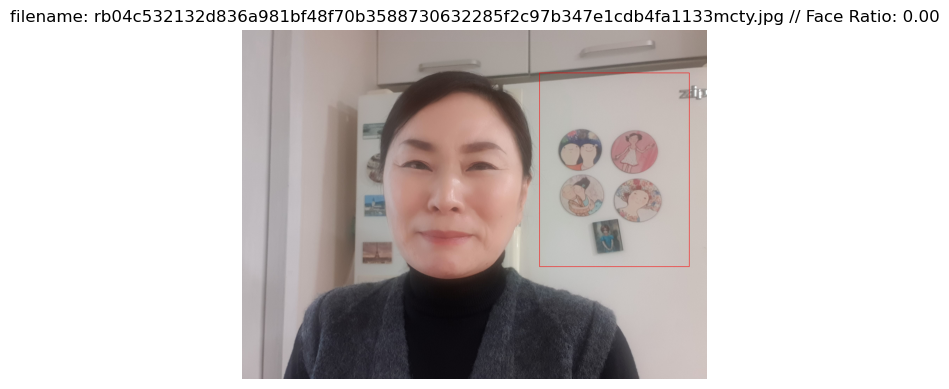

rb04c532132d836a981bf48f70b3588730632285f2c97b347e1cdb4fa1133mcty.jpg


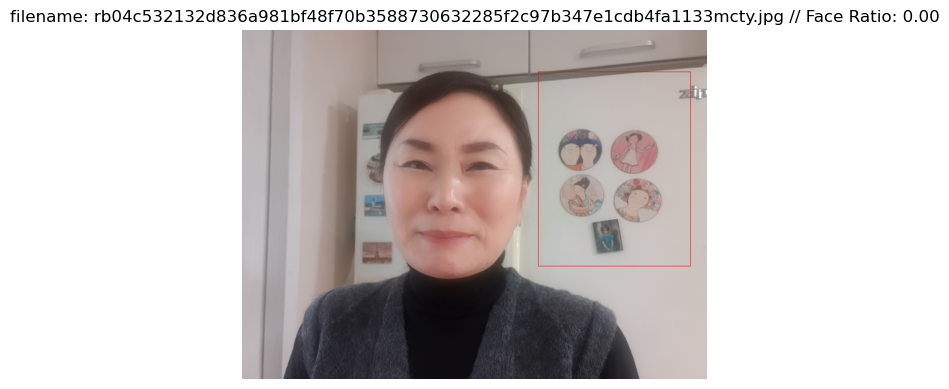

rb04c532132d836a981bf48f70b3588730632285f2c97b347e1cdb4fa1133mcty.jpg


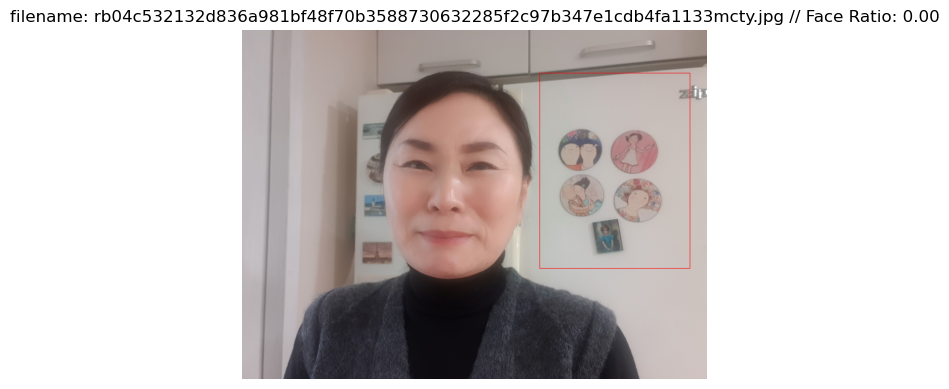

rb04c532132d836a981bf48f70b3588730632285f2c97b347e1cdb4fa1133mcty.jpg


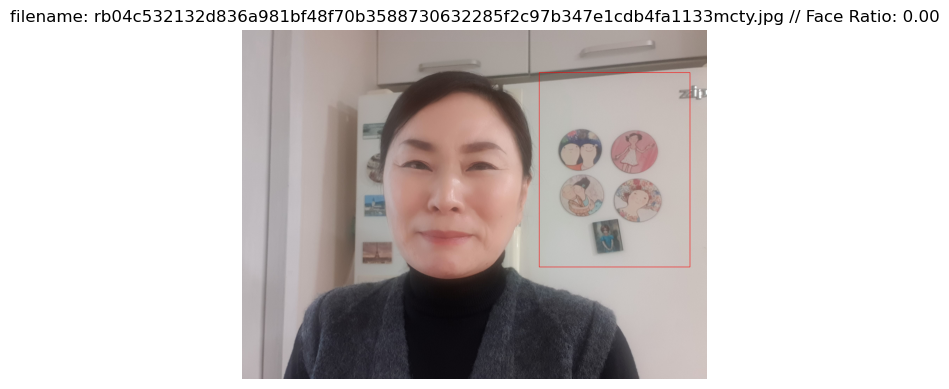

In [5]:

# 세그먼트 얼굴 영역을 확인하는 함수
def calculate_area(bbox):
    """ 바운딩 박스 면적 계산 """
    x_min, y_min, x_max, y_max = bbox
    return (x_max - x_min) * (y_max - y_min)

def calculate_face_area(face_segment, bbox, face_value=3):
    """ 얼굴 세그먼트가 바운딩 박스 내에서 차지하는 면적 계산 (face_value=3) """
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    # print(x_min, y_min, x_max, y_max)
    # 얼굴 세그먼트의 ROI (Region of Interest) 가져오기
    
    face_roi = face_segment[y_min:y_max, x_min:x_max]
    
    # 얼굴 영역에 대한 픽셀 값이 '3'인 (얼굴이 있는) 픽셀들 계산
    face_area = np.sum(face_roi == face_value)  # 값이 3인 픽셀의 개수
    
    return face_area

# 바운딩 박스를 그리는 함수
def draw_bbox_on_image(image, bbox, color=(255, 0, 0)):
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
    return image

# 이상치 탐지 함수
def detect_outliers_with_face(df, input_dir, npz_data, threshold=0.6, face_value=3):
    outliers = []

    # 각 이미지에 대해 바운딩 박스를 확인
    for index, row in df.iterrows():
        # if index == 50:
        #     break
        # 이미지 경로 및 바운딩 박스 좌표 가져오기
        image_path = input_dir + row['filename']
        
        # 이미지 로드
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 바운딩 박스 좌표들
        bboxes = [
            [row['annot_A.boxes.minX'], row['annot_A.boxes.minY'], row['annot_A.boxes.maxX'], row['annot_A.boxes.maxY']],
            [row['annot_B.boxes.minX'], row['annot_B.boxes.minY'], row['annot_B.boxes.maxX'], row['annot_B.boxes.maxY']],
            [row['annot_C.boxes.minX'], row['annot_C.boxes.minY'], row['annot_C.boxes.maxX'], row['annot_C.boxes.maxY']],
            [row['avg_box.minX'], row['avg_box.minY'], row['avg_box.maxX'], row['avg_box.maxY']],
        ]
        
        # npz_data에서 해당 이미지의 세그먼트 데이터 불러오기
        image_filename = row['filename']  # 파일명 기반으로 세그먼트 데이터 불러오기
        if image_filename in npz_data:
            face_segment = npz_data[image_filename]  # 해당 이미지의 세그먼트 데이터
            
            # 각 바운딩 박스에 대해 세그먼트 면적 확인
            for bbox in bboxes:
                bbox_area = calculate_area(bbox)
                face_area = calculate_face_area(face_segment, bbox, face_value)  # 얼굴 세그먼트 영역
                
                # 얼굴 면적이 바운딩 박스 면적의 60% 미만일 경우 이상치로 간주
                if face_area / bbox_area < threshold:
                    print(face_area / bbox_area * 100)
                    # 이상치로 간주하여 이미지를 그려줌
                    image_with_bbox = draw_bbox_on_image(image_rgb.copy(), bbox)
                    outliers.append({
                        'image': row['filename'],
                        'bbox': bbox,
                        'index': index,
                        'image_with_bbox': image_with_bbox,
                        'face_area': face_area,
                        'bbox_area': bbox_area,
                        'face_ratio': face_area / bbox_area,
                        'filename' : row['filename']
                    })
    
    return outliers

# 이상치 탐지 실행 예시
outliers = detect_outliers_with_face(df_val_sadness, img_path_val_sadness, npz_data, 0.4)

# 결과 출력 (이상치인 이미지를 시각화)
for outlier in outliers:
    print(outlier['filename'])
    plt.figure(figsize=(6, 6))
    plt.imshow(outlier['image_with_bbox'])
    plt.title(f"filename: {outlier['filename']} // Face Ratio: {outlier['face_ratio']:.2f}")
    plt.axis('off')
    plt.show()



In [11]:
# Segmentation 색상 설정 
# 0 : 보라색, 1 : 노란색, 2 : 빨간색, 3 : 초록색, 4 : 파란색, 5 : 주황색
from matplotlib.colors import ListedColormap
colors = ['purple', 'yellow', 'red', 'green', 'blue', 'orange']
cmap = ListedColormap(colors)

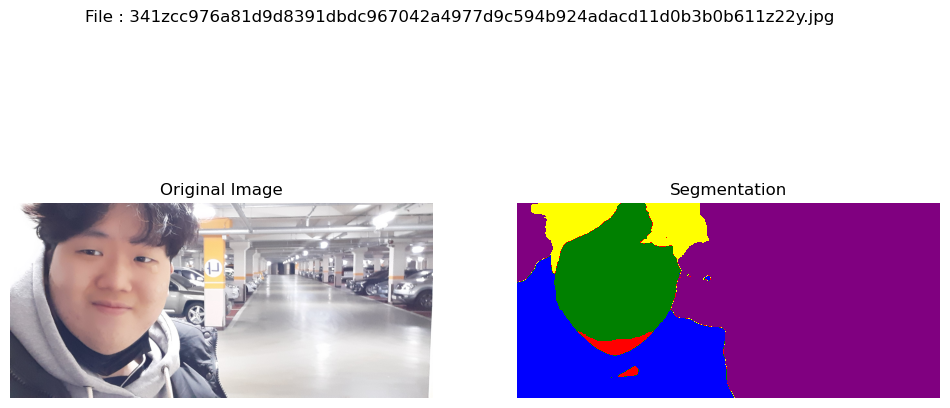

In [12]:
filename =  '341zcc976a81d9d8391dbdc967042a4977d9c594b924adacd11d0b3b0b611z22y.jpg'
data = npz_data[filename]  
happy_img_path = img_path_train + 'happy/'

# 원본 이미지 로드
image_path = os.path.join(happy_img_path, filename)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 시각화
plt.figure(figsize=(12,6))

# 원본 이미지
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Segmentation 시각화
plt.subplot(1,2,2)
plt.imshow(data, cmap=cmap, vmin=0, vmax=5)
plt.title("Segmentation")
plt.axis("off")

plt.suptitle(f"File : {filename}")
plt.show()

In [13]:
df_train_happy[df_train_happy['filename'] == filename]

,filename,faceExp_uploader,annot_A.boxes.maxX,annot_A.boxes.maxY,annot_A.boxes.minX,annot_A.boxes.minY,annot_B.boxes.maxX,annot_B.boxes.maxY,annot_B.boxes.minX,annot_B.boxes.minY,annot_C.boxes.maxX,annot_C.boxes.maxY,annot_C.boxes.minX,annot_C.boxes.minY,avg_box.maxX,avg_box.maxY,avg_box.minX,avg_box.minY
189,341zcc976a81d9d8391dbdc967042a4977d9c594b924ad...,기쁨,965.926647,861.093359,257.711377,-20.929709,966.536647,851.204359,265.313377,-20.468709,962.172647,857.736359,261.228377,-36.482709,964.878647,856.678026,261.417711,-25.960375
